In [89]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from sample import R

import chromatix.functional as cf
from chromatix.utils.fft import fft, ifft
from jax import Array
from jax.lax import scan
from jax.typing import ArrayLike
from sample import paper_sample
from tensor_tomo import outer, matvec, eps

from chromatix.utils import sigmoid_taper


%config InlineBackend.figure_format='retina'

In [24]:
# Getting shapes
size = (4.55, 11.7, 11.7)
spacing = 0.065

shape = np.around((np.array(size) / spacing)).astype(int) # without around becomes 1 less!

In [50]:
# center of pixel is our coordinate
z = jnp.linspace(1/2*spacing, size[0] - 1/2 * spacing, shape[0])
y = jnp.linspace(size[1] - 1/2 * spacing, 1/2 * spacing, shape[1])
x = jnp.linspace(1/2*spacing, size[2] - 1/2 * spacing, shape[2])
grid = jnp.stack(jnp.meshgrid(z, y, x, indexing="ij"), axis=-1) 

In [69]:
bead_pos = jnp.array([[size[0] / 2, 8.85, 2.85],
                      [size[0] / 2, 8.85, 8.85],
                      [size[0] / 2, 2.85, 2.85],
                      [size[0] / 2, 2.85, 8.85]])
rotation = jnp.array([[0.0, jnp.pi/2, 0.0], 
                      [0.0, 0.0,0.0],
                      [0.0, 0.0, jnp.pi/2], 
                      [jnp.pi/4, jnp.pi/4, jnp.pi/4]])

n_background = 1.33
n_bead = jnp.array([1.44, 1.40, 1.37])  # z y x
k0 = 2 * jnp.pi / 0.405  # mum
radius = 1.5

In [84]:
permitivitty = jnp.zeros((*shape, 1, 3, 3))

for pos, orientation in zip(bead_pos, rotation):
    # Making bead and background
    bead_permitivitty = R(*orientation).T @ jnp.diag(n_bead**2) @ R(*orientation)
    background_permitivitty = jnp.eye(3) * n_background**2

    # Mask
    mask = jnp.sum((grid - pos)**2, axis=-1) < radius ** 2

    # Making sample
    permitivitty += (k0**2 * jnp.where(
        mask[..., None, None, None], background_permitivitty - bead_permitivitty, jnp.zeros((3, 3))
    ))



In [85]:
permitivitty.shape

(70, 180, 180, 1, 3, 3)

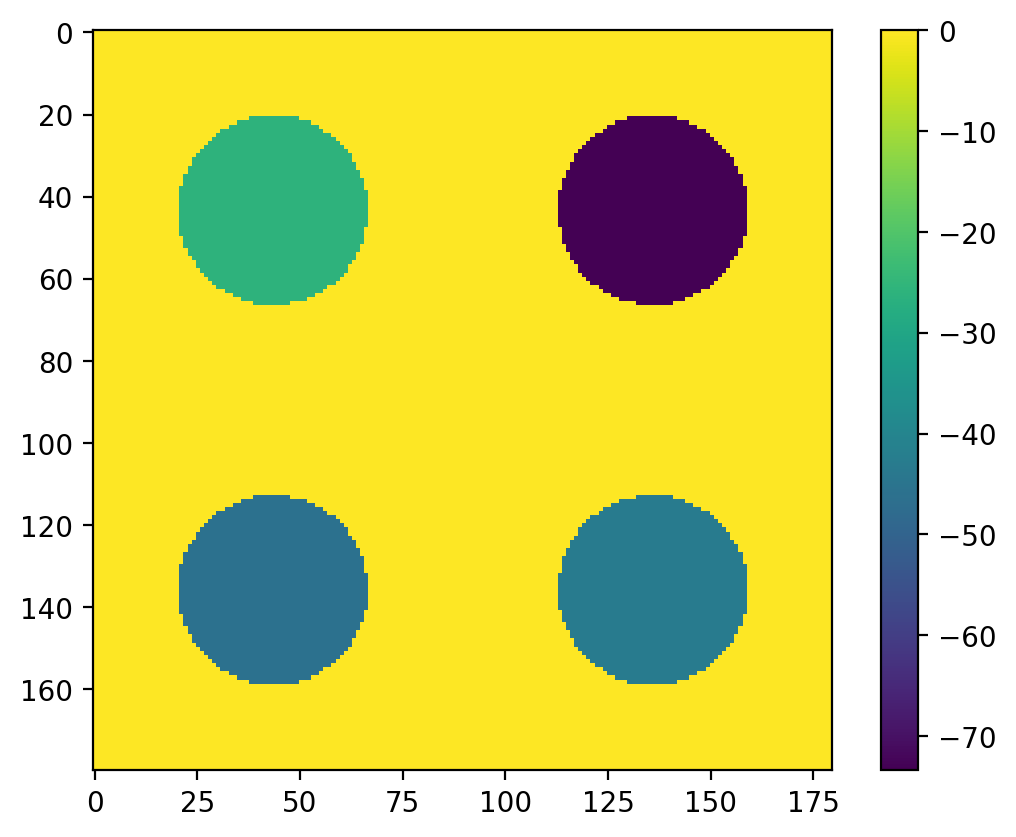

In [87]:
plt.imshow(permitivitty[35, :, :, 0, 0, 0])
plt.colorbar()

In [212]:
# Our input field is a plane wave
n_upscale = 5
shape = (n_upscale * 180, n_upscale * 180) # field size
spacing = 0.065 # from paper
wavelength = 0.405 # from paper
nm = 1.33
polarisation = cf.linear(0) # x-polarised light

in_field = cf.plane_wave(shape, spacing, wavelength, 1.0, amplitude=polarisation, scalar=False, power=100)
# Using gaussian beam
n_in = 300
in_field = in_field.replace(u=in_field.u * cf.center_pad(u=sigmoid_taper((n_in, n_in), 10), pad_width=(0, (shape[0] - n_in) // 2, (shape[1] - n_in) // 2, 0, 0)))
#in_field = in_field.replace(u=in_field.u * jnp.sqrt(jnp.exp(-jnp.sum(in_field.grid**2, axis=0) / (2 * 4.0**2)))) # gaussian 

Array([0.+0.j, 0.+0.j, 1.+0.j], dtype=complex64)

In [213]:
# Sample from the paper
sample = permitivitty 
print(f"Sample shape: {sample.shape}")

sample = cf.center_pad(sample, (0, (n_upscale-1)//2 * 180, (n_upscale-1) //2 * 180, 0, 0, 0))
print(f"Padded sample shape: {sample.shape}")


Sample shape: (70, 180, 180, 1, 3, 3)
Padded sample shape: (70, 900, 900, 1, 3, 3)


In [227]:
def thick_polarised_sample_evanescent(field: cf.VectorField, potential: ArrayLike, nm: ArrayLike, dz: ArrayLike) -> cf.VectorField:
    def Q_op(u: Array) -> Array:
        # correct
        """Polarisation transfer operator"""
        u = jnp.pad(u, padding)
        return ifft(matvec(Q, fft(u)))[:, n_pad[0]: -n_pad[0], n_pad[1]:-n_pad[1]]
    
    def H_op(u: Array) -> Array:
        # correct
        """Vectorial scattering operator"""
        u = jnp.pad(u, padding)
        prefactor = -1j / 2 * jnp.exp(1j * kz * dz) / kz * dz
        return ifft(matvec(Q, prefactor * fft(u)))[:, n_pad[0]: -n_pad[0], n_pad[1]:-n_pad[1]]
    
    def P_op(u: Array) -> Array:
        # correct
        """Vectorial free space operator"""
        u = jnp.pad(u, padding)
        prefactor =  jnp.exp(1j * kz * dz)
        return ifft(matvec(Q, prefactor * fft(u)))[:, n_pad[0]: -n_pad[0], n_pad[1]:-n_pad[1]]

    def propagate_slice(u: Array, potential_slice: Array) -> tuple[Array, None]:
        scatter_field = matvec(potential_slice, Q_op(u))
        new_field = P_op(u) + H_op(scatter_field)
        return new_field, new_field

   
    # We use z yx ordering, and add the 2pi factor to chromatix kgrrid
    # We chop off evanescent waves
    # NOTE: understand why we need nm here
    padded_shape = np.array(field.shape[1:3]) + np.array(potential.shape[1:3])
    n_pad = (padded_shape - np.array(field.shape[1:3])) // 2
    padding = ((0, 0), (n_pad[0], n_pad[0]), (n_pad[1], n_pad[1]), (0, 0), (0, 0))

    k_grid = 2 * jnp.pi * jnp.stack(jnp.meshgrid(jnp.fft.fftfreq(n=padded_shape[0], d=spacing), jnp.fft.fftfreq(n=padded_shape[1], d=spacing), indexing='ij'))[:, None, ..., None, None]
    km = 2 * jnp.pi * nm / field.spectrum
    kz = jnp.sqrt(km**2 - jnp.sum(k_grid**2, axis=0, dtype=jnp.complex64))
    k_grid =  jnp.concatenate([kz[None, ...], k_grid], axis=0)

    # Calculating PTFT
    Q = (-outer(k_grid / km, k_grid / km, in_axis=0) + jnp.eye(3)).squeeze(-3)

    # Running scan over sample
    u, intermediates = scan(propagate_slice, field.u, potential)
    return field.replace(u=u), intermediates

In [228]:
# Running the simulation
field, intermediates = thick_polarised_sample_evanescent(in_field, sample, 1.33, 0.065)

# Making plotting a little easier
# ::-1 to invert y axis
amplitude = field.amplitude.squeeze()
amplitude = amplitude[(n_upscale -1) // 2 * 180: shape[0] - (n_upscale -1) // 2 * 180, (n_upscale -1) // 2 * 180: shape[0] - (n_upscale -1) // 2 * 180]

phase = field.phase.squeeze()
phase = phase[(n_upscale -1) // 2 * 180: shape[0] - (n_upscale -1) // 2 * 180, (n_upscale -1) // 2 * 180: shape[0] - (n_upscale -1) // 2 * 180]

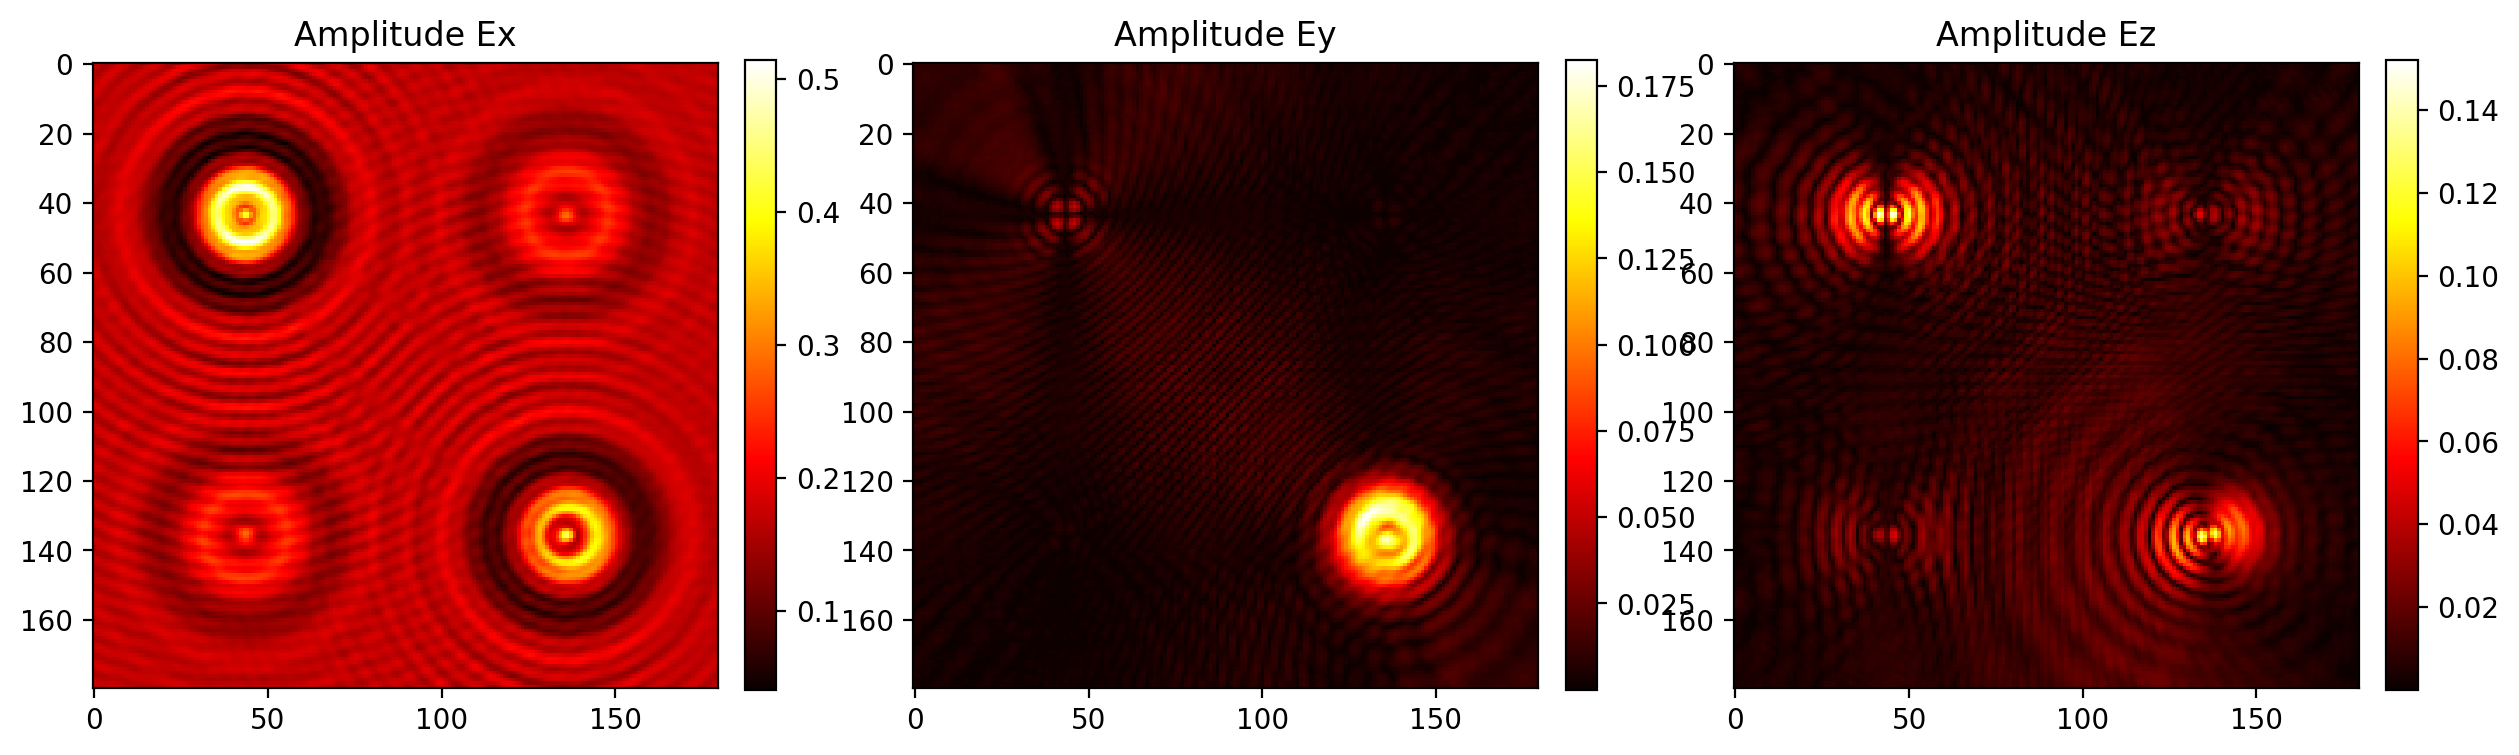

In [229]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title("Amplitude Ex")
plt.imshow(amplitude[..., 2], cmap="hot")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Amplitude Ey")
plt.imshow(amplitude[..., 1], cmap="hot")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.title("Amplitude Ez")
plt.imshow(amplitude[..., 0], cmap="hot")
plt.colorbar(fraction=0.046, pad=0.04)

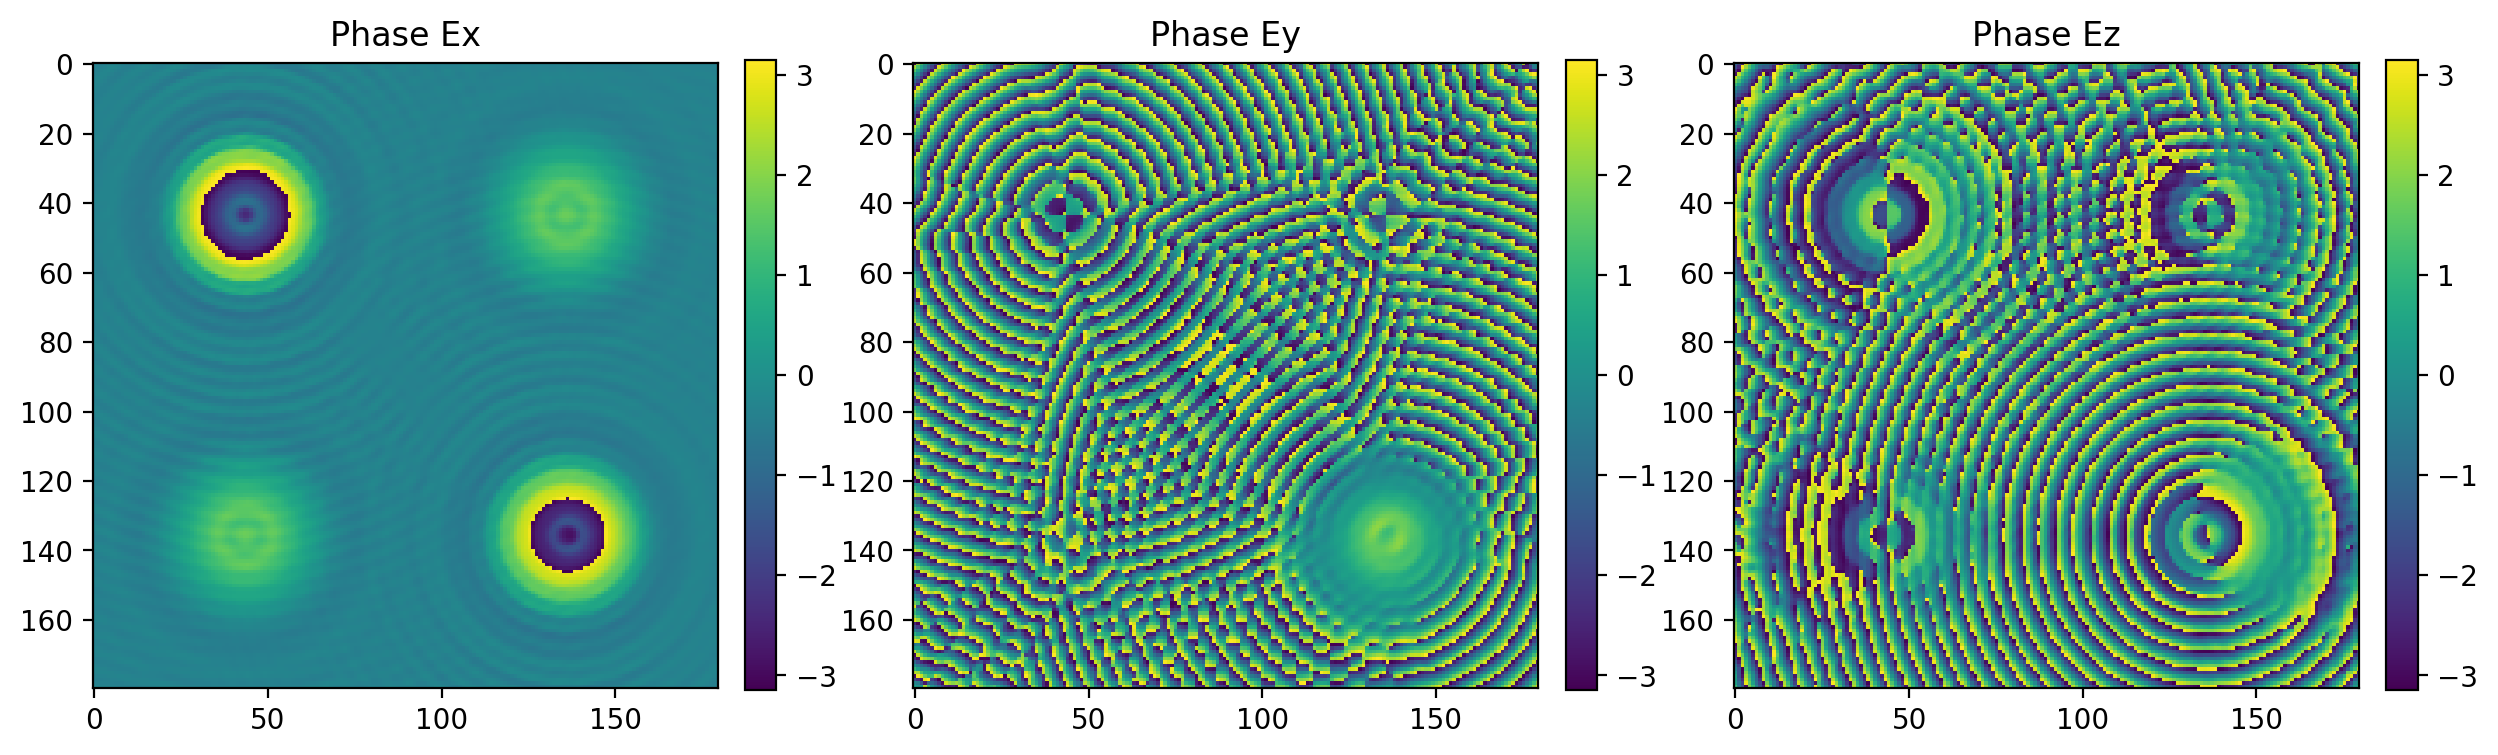

In [239]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title("Phase Ex")
plt.imshow(phase[..., 2])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Phase Ey")
plt.imshow(phase[..., 1])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.title("Phase Ez")
plt.imshow(phase[..., 0])
plt.colorbar(fraction=0.046, pad=0.04)

In [236]:
intermediates = intermediates.squeeze()[:, (n_upscale -1) // 2 * 180: shape[0] - (n_upscale -1) // 2 * 180, (n_upscale -1) // 2 * 180: shape[0] - (n_upscale -1) // 2 * 180]

In [238]:
intermediates.shape

(70, 0, 0, 3)

/var/folders/lq/md1nmdwx5qd2l88yv63dbqlw0000gp/T/ipykernel_64214/2696046715.py:1: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(jnp.abs(intermediates[5, ..., 2]))
/var/folders/lq/md1nmdwx5qd2l88yv63dbqlw0000gp/T/ipykernel_64214/2696046715.py:1: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(jnp.abs(intermediates[5, ..., 2]))


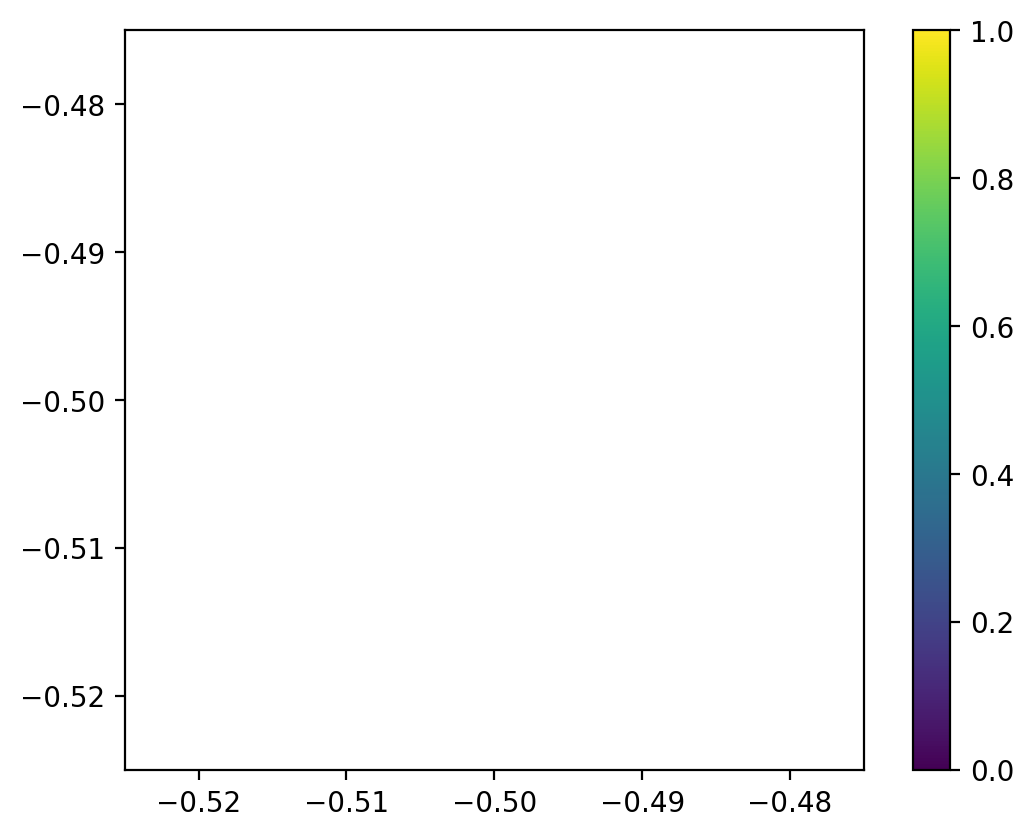

In [237]:
plt.imshow(jnp.abs(intermediates[5, ..., 2]))
plt.colorbar()